<a href="https://colab.research.google.com/github/akshatshah91/Game-AI/blob/master/DQN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [53]:
import gym
import random
import math
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
from torch import randint
import torch.nn.functional as F
import matplotlib.pyplot as plt
from IPython.display import clear_output
import warnings; warnings.simplefilter('ignore')
from collections import deque
import sys
import numpy as np

In [9]:
EPS_START = 1  # e-greedy threshold start value
EPS_END = 0.001  # e-greedy threshold end value
EPS_DECAY = 0.995  # e-greedy threshold decay
GAMMA = 0.8  # Q-learning discount factor
HIDDEN_LAYER = 256  # NN hidden layer size

FloatTensor = torch.FloatTensor
LongTensor = torch.LongTensor
ByteTensor = torch.ByteTensor
Tensor = FloatTensor

In [55]:
class DQN(nn.Module):
  def __init__(self, inputSize, outputSize):
    nn.Module.__init__(self)
    self.linear1 = nn.Linear(inputSize, HIDDEN_LAYER)
    self.linear2 = nn.Linear(HIDDEN_LAYER, outputSize)
  def forward(self, x):
    x = F.relu(self.linear1(x))
    return self.linear2(x)

In [108]:
class DQNAgent():
    def __init__(self, inputSize, outputSize, batchSize, learningRate):
        self.model = DQN(inputSize, outputSize)
        self.targetModel = copy.deepcopy(self.model)
        self.memory = deque(maxlen=256)
        self.batchSize = batchSize
        self.inputSize = inputSize
        self.outputSize = outputSize
        self.epsilon = 1
        self.optimizer1 = torch.optim.Adam(self.model.parameters(), lr=learningRate)
        self.optimizer2 = torch.optim.Adam(self.targetModel.parameters(), lr=learningRate)

    def store(self, transition):
      self.memory.append(transition)

    def act(self, state):
      if random.random() < self.epsilon:
        return random.randrange(self.outputSize)
      else:
        return np.argmax(self.model.forward(state).detach().numpy())

    def computeLoss(self, minibatch):
      state, action, reward, nextState, gameOver = zip(*minibatch)
      state = torch.FloatTensor(state)
      action = torch.LongTensor(action)
      reward = torch.FloatTensor(reward)
      nextState = torch.FloatTensor(nextState)
      gameOver = torch.FloatTensor(gameOver)
      action = action.view(action.size(0), 1)
      gameOver = gameOver.view(gameOver.size(0), 1)
      qVal1 = self.model.forward(state).gather(1,action)
      qVal2 = self.targetModel.forward(state).gather(1,action)
      nextQVal1 = self.model.forward(nextState)
      nextQVal2 = self.targetModel.forward(nextState)
      nextQVal = torch.min(torch.max(self.model.forward(nextState), 1)[0],torch.max(self.targetModel.forward(nextState), 1)[0])
      nextQVal = nextQVal.view(nextQVal.size(0), 1)
      expectedQVal = reward + (1 - done) * GAMMA * nextQVal
      loss1 = F.mse_loss(qVal1, expectedQVal.detach())
      loss2 = F.mse_loss(qVal2, expectedQVal.detach())
      return loss1,loss2

    def update(self):
      if len(self.memory) < self.batchSize:
        return
      minibatch = random.sample(self.memory, k=self.batchSize)
      loss1,loss2 = self.computeLoss(minibatch)
      self.optimizer1.zero_grad()
      self.optimizer2.zero_grad()
      loss1.backward()
      loss2.backward()
      self.optimizer1.step()
      self.optimizer2.step()
      if self.epsilon > EPS_END:
        self.epsilon *= EPS_DECAY

In [96]:
def train(env, stateSize, actionSize, fig, batchSize, learningRate):
  print("------HYPERPARAMETERS------")
  print("Batch Size =", batchSize)
  print("Learning Rate =", learningRate)
  print("---------------------------")
  agent = DQNAgent(stateSize, actionSize, batchSize, learningRate)
  rewards = []
  avg = []
  ep = []
  avgInterval = int(EPISODES/50)
  for x in range(1, EPISODES+1):
    state = env.reset()
    gameOver = False
    total = 0
    while not gameOver:
      action = agent.act(torch.FloatTensor(state))
      nextState,reward,gameOver,_ = env.step(action)
      agent.store((state, action, reward, nextState, gameOver))
      state = nextState
      total += reward
      agent.update()
    rewards.append(total)
    if x % avgInterval == 0:
      avg.append(sum(rewards[-avgInterval:])/avgInterval)
      ep.append(x)
  plt.figure(fig)
  plt.xlabel("Episode")
  plt.ylabel("Score")
  plt.plot(rewards)
  plt.plot(ep, avg)
  plt.show()
  label = "Batchsize=" + str(batchSize) + " LR=" + str(learningRate)
  return (ep, avg, label)

In [36]:
env = gym.make('CartPole-v0').env
stateSize = env.observation_space.shape[0]
actionSize = env.action_space.n
EPISODES = 5000

avgRewards = []
batchSizes = [16, 64]
learningRates = [0.001, 0.005]
x = 1
for b in batchSizes:
  for l in learningRates:
    avgRewards.append(train(env, stateSize, actionSize, x, b, l))
    x += 2

plt.figure(0)
plt.xlabel("Episodes")
plt.ylabel("Score")
for e,a,l in avgRewards:
  plt.plot(e, a, label=l)
plt.legend()

------HYPERPARAMETERS------
Batch Size = 16
Learning Rate = 0.001
---------------------------


RuntimeError: ignored

------HYPERPARAMETERS------
Batch Size = 10
Learning Rate = 0.001
---------------------------


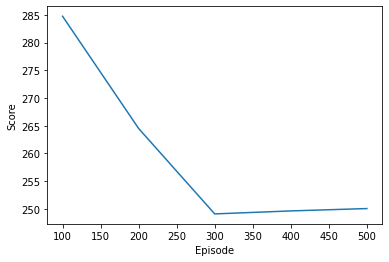

------HYPERPARAMETERS------
Batch Size = 10
Learning Rate = 0.005
---------------------------


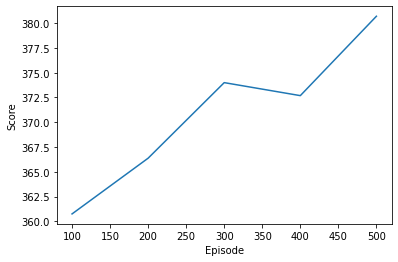

------HYPERPARAMETERS------
Batch Size = 64
Learning Rate = 0.001
---------------------------


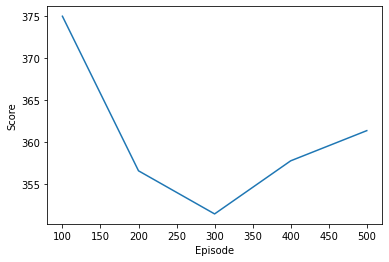

------HYPERPARAMETERS------
Batch Size = 64
Learning Rate = 0.005
---------------------------


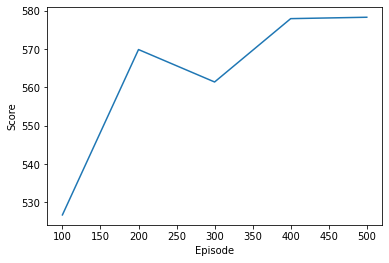

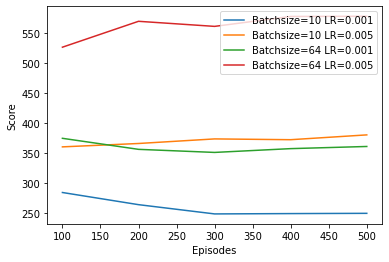

In [ ]:
env = gym.make('AirRaid-ram-v0').env
stateSize = env.observation_space.shape[0]
actionSize = env.action_space.n
EPISODES = 500

avgRewards = []
batchSizes = [16, 64]
learningRates = [0.001, 0.005]
trainingIterations = [1, 4]
x = 1
for b in batchSizes:
  for l in learningRates:
    for t in trainingIterations:
      avgRewards.append(train(env, stateSize, actionSize, x, b, l, t))
      x += 1

plt.figure(0)
plt.xlabel("Episodes")
plt.ylabel("Score")
for e,a,l in avgRewards:
  plt.plot(e, a, label=l)
plt.legend()